# Task:
Implement for a useful nontrivial use case of your choice the EM Algorithm
(e.g., three coins, two dice, two Gaussians, two different non-Gaussians),
surrogate data creation included. Nice documentation, commenting, presentations, take homes and animations are welcome.

## About EM Algorithm (Expectation-maximization algorithm)

The Expectation-Maximization (EM) algorithm is a method used in statistics to estimate the parameters of complex probability models. This algorithm is particularly suitable for situations where model parameters are not easily observed or calculated directly. We can think of it as a "guess-and-check" process used to progressively approximate the correct model parameters.



### Simple Explanation:

Imagine you are a detective trying to uncover the truth about an incident, but you only have incomplete clues. The EM algorithm is like initially making a preliminary guess based on the available clues (the Expectation step), then searching for more evidence to see if this guess makes sense (the Maximization step). By continuously guessing and verifying, you gradually get closer to the truth of the incident.

### Specific Steps:

1. **Expectation Step (E-step)**: Based on the current estimate of parameters, calculate or "guess" the values of hidden variables. This is like speculating possible scenarios based on the existing clues.

2. **Maximization Step (M-step)**: Update the estimation of parameters to make the model more "reasonable" for the observed data. This is similar to adjusting your clues and hypotheses based on new speculations to make the explanation of the case more reasonable.

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np

## 2 Dice  Problem ##

We decided to implement the EM Algorithm for 2 Dice Problem. 

For each experiment:
- A random selection is made between Dice A and Dice B, with equal probability for each.
- If Dice A is selected, it uses the custom probability distribution specified by the 'prob_A' array.
- If Dice B is selected, it uses the custom probability distribution specified by the 'prob_B' array.
- The model then generates 'dice_rolls' - number of rolls for the selected die type and records the outcomes.

In [2]:
def generate_dice_data(experiments, dice_rolls, prob_A, prob_B):

    '''This function generates experimental data for a specified number of experiments using two types of dice: Dice A and Dice B.

    - Dice A: a custom die with a probability distribution specified by the 'prob_B' array provided as an argument to the function.
    - Dice B: a custom die with a probability distribution specified by the 'prob_B' array provided as an argument to the function.

    The function takes three arguments:
    1. experiments: The number of experiments to be conducted.
    2. dice_rolls: The number of rolls for each experiment.
    3. prob_B: An array specifying the probability distribution for Dice B.

    The function returns two lists:
    1. results: A list containing tuples, where each tuple represents the type of die used ('A' or 'B') and the outcomes of the rolls for that experiment.
    2. dice_types: A list containing the type of die used for each experiment ('A' or 'B').
    '''
    # Results will store the outcomes of each experiment
    # Dice types will store the type of dice used in each experiment
    results = []
    dice_types = []

    # Loop through the specified number of experiments
    for _ in range(experiments):
        trial = []  # Store the outcomes of a single experiment
        
        # Randomly choose between dice A and dice B with equal probability
        if random.random() < 0.5:
            dice_type = 'A'
            probabilities = prob_A  # Dice A: custom probability distribution provided as prob_B
        else:
            dice_type = 'B'
            probabilities = prob_B  # Dice B: custom probability distribution provided as prob_B
        
        # Generate dice_rolls number of rolls for the selected die type
        for _ in range(dice_rolls):
            # Randomly select an outcome based on the probabilities of each face
            outcome = random.choices(range(1, 7), weights=probabilities)[0]
            trial.append(outcome)
        
        # Append the experiment's results (type of die and outcomes) to the results list
        results.append((dice_type, trial))
        
        # Append the type of die used in this experiment to the dice_types list
        dice_types.append(dice_type)
    
    # Return the results and dice types
    return results, dice_types


In [3]:
#EM algorithm
def dice_em(rolls, theta_A, theta_B, max_iter=25): 
    """
    Runs the Expectation-Maximization (EM) algorithm to estimate the probabilities of each face of two dice.

    Args:
        rolls (list): A list of tuples, where each tuple contains the type of dice ('A' or 'B') and the outcomes of the rolls for one experiment.
        theta_A (numpy.ndarray): Initial guess for the probabilities of each face of dice A. Defaults to None.
        theta_B (numpy.ndarray): Initial guess for the probabilities of each face of dice B. Defaults to None.
        max_iter (int): Maximum number of iterations for the EM algorithm. Defaults to 25.

    Returns:
        numpy.ndarray: Estimated probabilities of each face of dice A.
        numpy.ndarray: Estimated probabilities of each face of dice B.
        list: History of estimated probabilities of each face of dice A for each iteration.
        list: History of estimated probabilities of each face of dice B for each iteration.
    """
    

    theta_A_history = []
    theta_B_history = []
    
    theta_A_history.append(theta_A.copy())
    theta_B_history.append(theta_B.copy())
    
    # Iterate
    for i in range(max_iter):
        #print("#%d:\t%0.4f %0.4f" % (i, theta_A, theta_B)) #significant digits 
        result_A,result_B = e_step( rolls, theta_A, theta_B )
        theta_A, theta_B = m_step( result_A,result_B )
        theta_A_history.append(theta_A.copy())
        theta_B_history.append(theta_B.copy())
    return theta_A, theta_B, theta_A_history, theta_B_history #thetas are conveniently needed for a unnecessary plot at the end


def e_step( rolls, theta_A, theta_B ):
    """
    E step of the EM algorithm: Estimate the expected counts of each face for dice A and dice B.

    Args:
        rolls (list): A list of tuples, where each tuple contains the type of dice ('A' or 'B') and the outcomes of the rolls for one experiment.
        theta_A (numpy.ndarray): Probabilities of each face of dice A.
        theta_B (numpy.ndarray): Probabilities of each face of dice B.

    Returns:
        numpy.ndarray: Expected counts of each face for dice A.
        numpy.ndarray: Expected counts of each face for dice B.
    """
    result_A = np.zeros(6) 
    result_B = np.zeros(6)
    for type, trial in rolls:
        likelihood_A =  dice_likelihood( trial, theta_A )
        likelihood_B = dice_likelihood( trial, theta_B )
        p_A = likelihood_A / ( likelihood_A + likelihood_B )
        p_B = likelihood_B / ( likelihood_A + likelihood_B )
        
        count = np.zeros(6)
        for i in range(1,7):
            count[i-1] = trial.count(i) 
        result_A += p_A * count
        result_B += p_B * count
    return result_A, result_B

# M step: Compute values for theta that maximize the likelihood of expected number of heads/tails
def m_step(result_A, result_B):
    """
    M step of the EM algorithm: Update the parameters theta_A and theta_B based on the expected counts.

    Args:
        result_A (numpy.ndarray): Expected counts of each face for dice A.
        result_B (numpy.ndarray): Expected counts of each face for dice B.

    Returns:
        numpy.ndarray: Updated probabilities of each face of dice A.
        numpy.ndarray: Updated probabilities of each face of dice B.
    """
    theta_A = np.zeros(6)  # Initialize updated probabilities for dice A
    theta_B = np.zeros(6)  # Initialize updated probabilities for dice B
    
    for i in range(6):
        # Update the probabilities of each face for dice A and dice B
        theta_A[i] = result_A[i] / result_A.sum()
        theta_B[i] = result_B[i] / result_B.sum()
    
    return theta_A, theta_B

def dice_likelihood(roll_sequence, theta):
    """
    Compute the likelihood of a sequence of dice rolls given the probabilities of each face.

    Args:
        roll_sequence (list): A sequence of outcomes of dice rolls.
        theta (numpy.ndarray): Probabilities of each face of the dice.

    Returns:
        float: Likelihood of the roll sequence given the probabilities.
    """

    indices = np.array(roll_sequence) - 1  # Convert roll outcomes to 0-indexed array
    return np.prod(np.take(theta, indices))  # Compute the product of probabilities for each outcome

def random_dice():
    theta_A = np.random.rand(6)
    return  theta_A/theta_A.sum()


In [4]:
def plot_dice_likelihood(rolls, theta_A_history, theta_B_history):
    """
    Plot the likelihood evolution for each face of dice A and dice B over iterations.

    Args:
        rolls (list): A list of tuples, where each tuple contains the type of dice ('A' or 'B') and the outcomes of the rolls for one experiment.
        theta_A_history (list): History of estimated probabilities of each face of dice A for each iteration.
        theta_B_history (list): History of estimated probabilities of each face of dice B for each iteration.
    """

    # Set the size of the figure
    plt.figure(figsize=(18, 6))

    # Plot the probability evolution for each face of dice A
    plt.subplot(1, 2, 1)
    for i in range(6):
        plt.plot([theta[i] for theta in theta_A_history], label=f'Face {i+1}')
    plt.ylim(0, 1)
    plt.title('Probability Estimations for Dice A Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Probability')
    plt.legend()

    # Plot the probability evolution for each face of dice B
    plt.subplot(1, 2, 2)
    for i in range(6):
        plt.plot([theta[i] for theta in theta_B_history], label=f'Face {i+1}')
    plt.ylim(0, 1)
    plt.title('Probability Estimations for Dice B Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Probability')
    plt.legend()

    # Adjust layout to prevent overlap of subplots
    plt.tight_layout()

    # Show the plot
    plt.show()


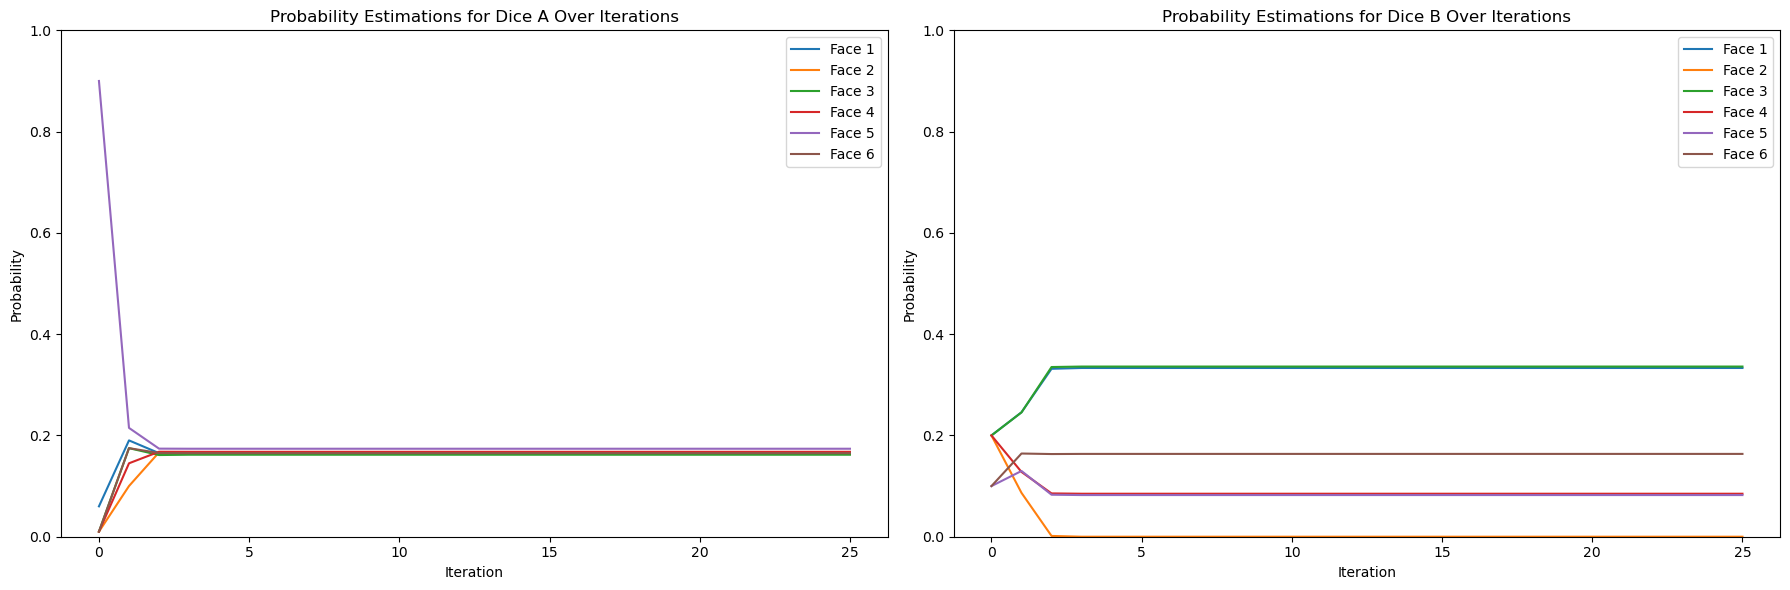

Final estimated probabilities for Estimation 1: [0.165      0.16663462 0.16192308 0.16769231 0.17375    0.165     ]
The Real probabilities for Estimation 1: [0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
Final estimated probabilities for Estimation 2: [0.33322917 0.         0.33604167 0.08489583 0.08229167 0.16354167]
The Real probabilities for Estimation 2: [0.3333333333333333, 0, 0.3333333333333333, 0.08333333333333333, 0.08333333333333333, 0.16666666666666666]
SSR of Estimation 1: 7.92837771203154e-05
SSR of Estimation 2: 2.063802083333346e-05


In [11]:
# Generate experimental data for 100 experiments, each consisting of 200 dice rolls,
# using two types of dice: one with uniform probabilities for each face (Dice A),
# and another with custom probabilities specified by the provided array (Dice B).

diceA = [ 1/6] * 6
diceB = [2/6, 0, 2/6, 1/12, 1/12, 1/6]
data, dice_types = generate_dice_data(100, 200, diceA, diceB)

theta_A=[6/100, 1/100, 1/100, 1/100, 90/100, 1/100]
theta_B=[1/5, 1/5,1/5, 1/5, 1/10,1/10]

# Apply the Expectation-Maximization (EM) algorithm to estimate the probabilities
# of each face for both types of dice using the generated experimental data.
# The final_theta_A and final_theta_B variables will contain the estimated probabilities
# of each face for Dice A and Dice B, respectively.
final_theta_A, final_theta_B, theta_A_history, theta_B_history = dice_em(data, theta_A, theta_B)

# Plot the evolution of probability estimates for each face of Dice A and Dice B
# over the iterations of the EM algorithm, using the provided data and the
# history of estimated probabilities.
plot_dice_likelihood(data, theta_A_history, theta_B_history)

# Print the final estimated probabilities of each face for Dice A and Dice B.
print("Final estimated probabilities for Estimation 1:", final_theta_A)
print("The Real probabilities for Estimation 1:",diceA)
print("Final estimated probabilities for Estimation 2:", final_theta_B)
print("The Real probabilities for Estimation 2:",diceB)
print('SSR of Estimation 1:', np.sum((final_theta_A - diceA) ** 2))
print('SSR of Estimation 2:', np.sum((final_theta_B - diceB) ** 2))

The graphs illustrate the iterative process of the Expectation-Maximization algorithm estimating probabilities for two dice. The left graph shows the probability estimates for Dice A starting from a highly skewed initial guess and converging to a stable solution over more iterations. The right graph depicts the probability estimates for Dice B, which quickly converges to its stable solution, indicating more accurate initial probability estimates for this dice.

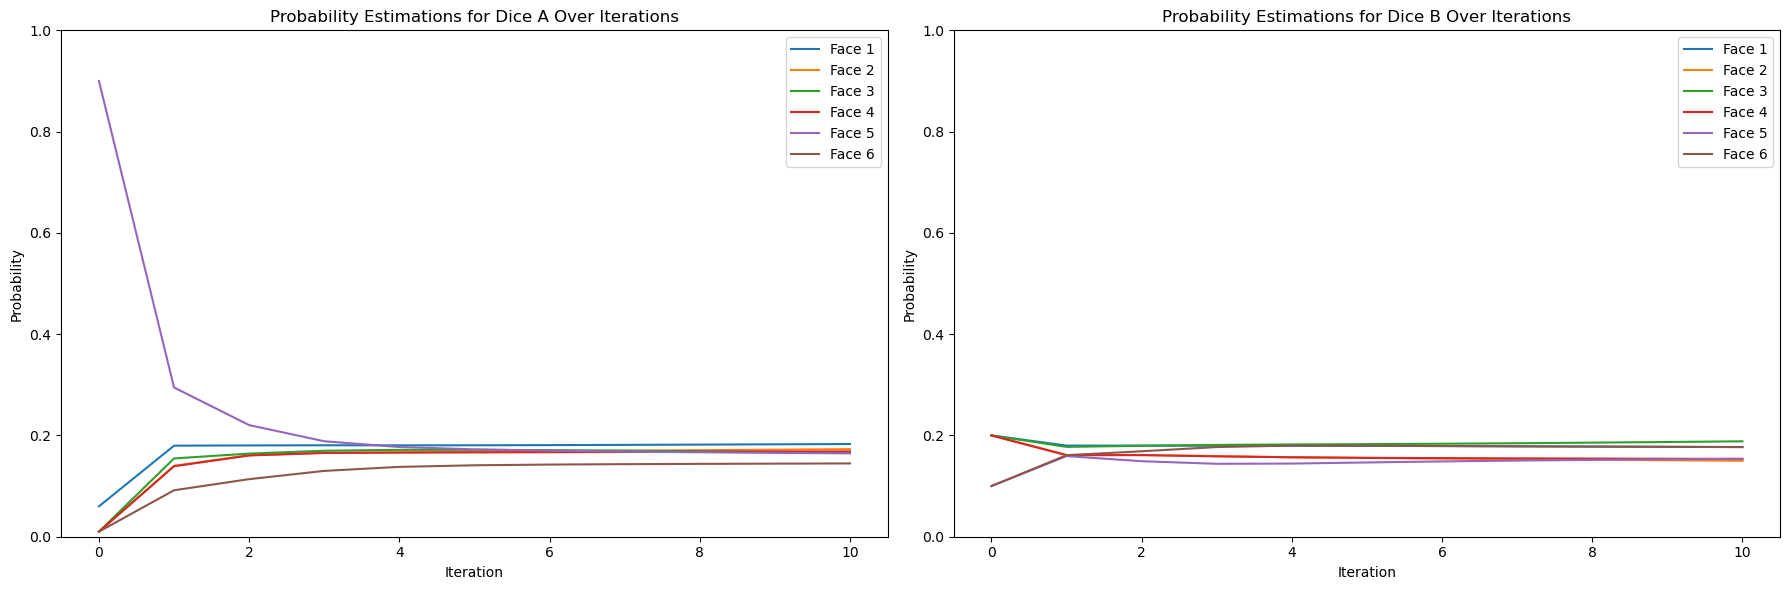

Final estimated probabilities for Estimation 1: [0.18304728 0.17295066 0.16629747 0.16838415 0.16456726 0.14475318]
The Real probabilities for Estimation 1: [0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
Final estimated probabilities for Estimation 2: [0.17697458 0.14993218 0.1884229  0.15366881 0.15387123 0.1771303 ]
The Real probabilities for Estimation 2: [0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
SSR of Estimation 1: 0.0007955076385506752
SSR of Estimation 2: 0.0013017847972581229


In [7]:
diceA = [ 1/6] * 6
diceB = [ 1/6] * 6
data, dice_types = generate_dice_data(100, 50, diceA, diceB)
theta_A=[6/100, 1/100, 1/100, 1/100, 90/100, 1/100]
theta_B=[1/5, 1/5,1/5, 1/5, 1/10,1/10]
final_theta_A, final_theta_B, theta_A_history, theta_B_history = dice_em(data,theta_A,theta_B,10)
plot_dice_likelihood(data, theta_A_history, theta_B_history)
print("Final estimated probabilities for Estimation 1:", final_theta_A)
print("The Real probabilities for Estimation 1:",diceA)
print("Final estimated probabilities for Estimation 2:", final_theta_B)
print("The Real probabilities for Estimation 2:",diceB)
print('SSR of Estimation 1:', np.sum((final_theta_A - diceA) ** 2))
print('SSR of Estimation 2:', np.sum((final_theta_B - diceB) ** 2))

Choice of theta will influence the speed of convergence for the left plot; initial theta is unequal, so it converges very slowly compared to the right plot (relative equal theta).

This means that the initial guesses (theta values) for the probabilities of each face of Dice A were quite skewed, with one outcome having a much higher probability than the others. This has caused the EM algorithm to converge more slowly because the initial parameter estimates were further from the true probabilities. On the other hand, the initial theta values for Dice B were more balanced, resulting in a faster convergence to the true probabilities.

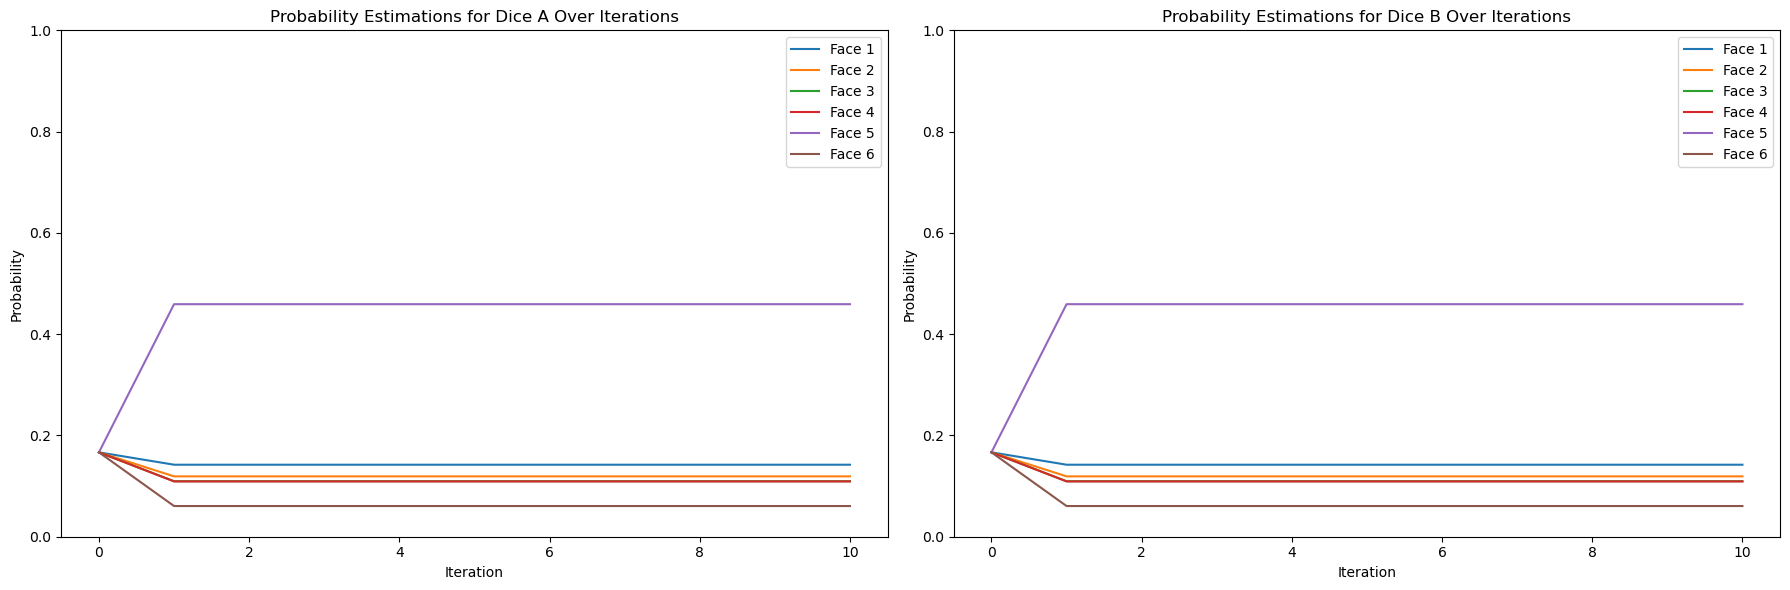

Final estimated probabilities for Estimation 1: [0.1422 0.1192 0.1096 0.1092 0.4592 0.0606]
The Real probabilities for Estimation 1: [0.06, 0.01, 0.01, 0.01, 0.9, 0.01]
Final estimated probabilities for Estimation 2: [0.1422 0.1192 0.1096 0.1092 0.4592 0.0606]
The Real probabilities for Estimation 2: [0.2, 0.2, 0.2, 0.2, 0.1, 0.1]
SSR of Estimation 1: 0.23530728000000004
SSR of Estimation 2: 0.15686327999999997


In [8]:
diceA=[6/100, 1/100, 1/100, 1/100, 90/100, 1/100]
diceB=[1/5, 1/5,1/5, 1/5, 1/10,1/10]
data, dice_types = generate_dice_data(100, 50, diceA, diceB)

theta_A = [ 1/6] * 6
theta_B= [ 1/6] * 6
final_theta_A, final_theta_B, theta_A_history, theta_B_history = dice_em(data,theta_A,theta_B,10)
plot_dice_likelihood(data, theta_A_history, theta_B_history)
print("Final estimated probabilities for Estimation 1:", final_theta_A)
print("The Real probabilities for Estimation 1:",diceA)
print("Final estimated probabilities for Estimation 2:", final_theta_B)
print("The Real probabilities for Estimation 2:",diceB)
print('SSR of Estimation 1:', np.sum((final_theta_A - diceA) ** 2))
print('SSR of Estimation 2:', np.sum((final_theta_B - diceB) ** 2))

if we set the initial theta to the same, the results can stop at the saddle point. This indicates that if the initial probabilities are identical for both dice, the EM algorithm may converge to a local optimum probability rather than the true probabilities, leading to suboptimal estimations. We can clearly see that there seems to be a mismatch for many probabilites for both Dice A and Dice  B. The most major discrepency is seen for face 5 of Dice A and face 5 of Dice B. 

## Take Home Message ##

The three graphs collectively demonstrate important characteristics and considerations when using the Expectation-Maximization (EM) algorithm for probability estimation:

Utility of the Algorithm: The EM algorithm is shown to be a powerful tool for estimating the probabilities of different outcomes from a given set of data. When the initial parameters are chosen appropriately, the algorithm can converge to values that closely approximate the true probabilities.
Influence of Initial Values on Convergence Speed: The initial values of the parameters can significantly affect the speed at which the EM algorithm converges. If the initial values are close to the true probabilities, the algorithm converges faster. If they are not, the algorithm may take more iterations to reach the true probabilities, as seen in the second graph.
Potential Issues with Identical Initial Values: Using the same initial values for all parameters may lead to convergence issues, such as stopping at a saddle point rather than at the optimal solution. This is evident from the third graph, where the algorithm does not converge to the correct probabilities due to the choice of identical initial values.

**The take-home message is that while the EM algorithm is effective for estimating hidden parameters, the choice of initial values is crucial. Good initial estimates lead to faster convergence and avoid potential pitfalls like convergence to saddle points.**